In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.conv_learner import *
import json
from matplotlib import patches, patheffects

In [3]:
PATH = Path('data/pascal')
# list(PATH.iterdir())
!ls {PATH}

PASCAL_VOC.zip              pascal_train2007.json
VOCdevkit                   pascal_train2012.json
VOCtrainval_06-Nov-2007.tar pascal_val2007.json
models                      pascal_val2012.json
pascal_test2007.json        tmp


In [4]:
JPEGS = 'VOCdevkit/VOC2007/JPEGImages'
IM_PATH = PATH/JPEGS

In [5]:
trn_json = json.load( (PATH/'pascal_train2007.json').open() )  # call open on the PosixPath object
trn_json.keys()

dict_keys(['images', 'type', 'annotations', 'categories'])

In [6]:
cats = {row['id']: row['name'] for row in trn_json['categories']}
trn_imgs = {row['id']: row['file_name'] for row in trn_json['images']}
trn_ids = list(trn_imgs.keys())

## dictionary => key: image_id, value: ([annotations],category_id)

In [7]:
def hw_bb(a): return np.array([a[1], a[0], a[3]+a[1], a[2]+a[0]])

trn = collections.defaultdict(lambda: [])
for row in trn_json['annotations']:
    if not row['ignore']: 
        bb = row['bbox']
        bb = hw_bb(bb)
        # PASCALVOC defaults to (col,row) of top left, height, width
        # we use (row,col) of top left, row,col of bottom right
        trn[row['image_id']].append((bb,row['category_id']))
        # appending because we're using [] as our default dict -> allows us to add multiple bboxes per image

In [8]:
def bb_hw(a): return np.array([a[1], a[0], a[3]-a[1], a[2]-a[0]])

## image display functions

In [9]:
def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.axis('off')
    return ax

In [10]:
def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(linewidth=lw, foreground='black'), patheffects.Normal()])
    # draws the path twice, once w/ thick black line, again with color below

In [11]:
def draw_rectangle(ax, b, color='white'):
    o = ax.add_patch(patches.Rectangle(b[:2], *b[2:], fill=False, edgecolor=color, lw=2))
    draw_outline(o, 4)

In [12]:
def draw_text(ax, xy, txt, sz=14, color='white'):
    o = ax.text(*xy, txt, verticalalignment='top', color=color, fontsize=sz, weight='bold')
    draw_outline(o, 2)

In [13]:
def draw_img(im, anno):
    ax = show_img(im, figsize=(10,6))
    for b,c in anno:
        b = bb_hw(b)
        draw_rectangle(ax, b)
        draw_text(ax, b[:2], cats[c])

In [14]:
def draw_idx(idx):
    im = open_image(IM_PATH/trn_imgs[idx])
    draw_img(im, trn[idx])
    print(im.shape)

(281, 500, 3)


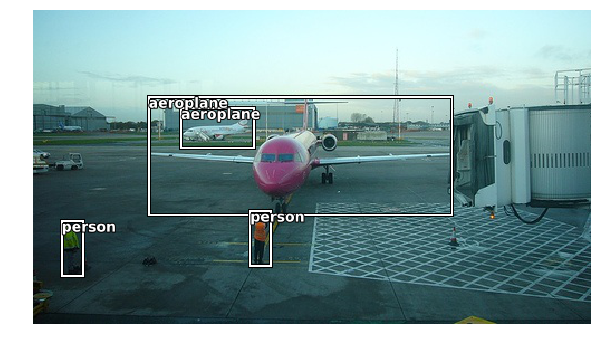

In [56]:
draw_idx(32)

# largest item classifier

In [21]:
def get_lrg(o):
    # some are empty lists due to collections.defaultdict
    if o:
        # area = (bb[2]-bb[0])*(bb[3]-bb[1])
        return sorted(o, key=lambda x: np.product(x[0][-2:]-x[0][:2]), reverse=True)[0]

In [22]:
lrg_trn = {k: get_lrg(v) for k,v in trn.items()}

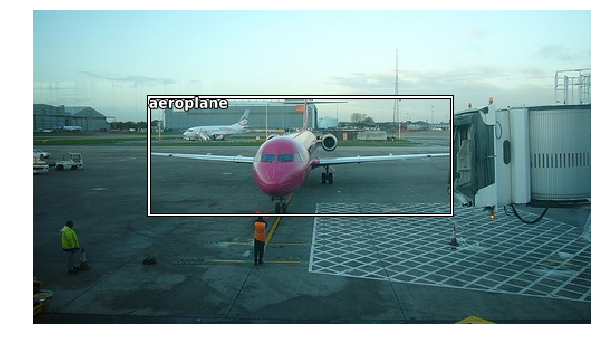

In [23]:
# check that it worked...
i = 32
im = open_image(IM_PATH/trn_imgs[i])
draw_img(im, [lrg_trn[i]])

In [24]:
(PATH/'tmp').mkdir(exist_ok=True)
CSV = PATH/'tmp'/'largest_obj.csv'

In [25]:
df = pd.DataFrame({'filename': [trn_imgs[i] for i in trn_ids],
                   'class': [cats[lrg_trn[i][1]] for i in trn_ids]},
                   columns=['filename', 'class'])
df.to_csv(CSV, index=False)

In [89]:
f = resnet34
sz = 224
bs = 64

In [90]:
tfms = tfms_from_model(f, sz, aug_tfms=transforms_side_on, crop_type=CropType.NO) # no crop, only squish
md = ImageClassifierData.from_csv(PATH, JPEGS, CSV, bs=bs, tfms=tfms)  
learn = ConvLearner.pretrained(f, md, ps=0.3, precompute=True)

A Jupyter Widget

epoch      trn_loss   val_loss   accuracy                 
    0      4.328999   708.988061 0.204     



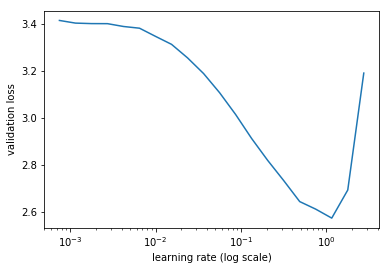

In [58]:
learn.lr_find()
learn.sched.plot(n_skip_end=1)

In [91]:
lr = 1e-1

In [92]:
learn.fit(lr, 3, cycle_len=1, wds=1e-4)

A Jupyter Widget

epoch      trn_loss   val_loss   accuracy                 
    0      1.345266   0.64059    0.792     
    1      0.937877   0.669206   0.812                     
    2      0.72258    0.675073   0.806                     


[0.67507310342788696, 0.8059999976158142]

### Precompute => sneaky!!!

In [40]:
learn.precompute = True  # only final layers are accessible to learner

# learn.model
# Sequential(
#   (0): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
#   (1): Dropout(p=0.3)
#   (2): Linear(in_features=1024, out_features=512, bias=True)
#   (3): ReLU()
#   (4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
#   (5): Dropout(p=0.3)
#   (6): Linear(in_features=512, out_features=20, bias=True)
#   (7): LogSoftmax()
# )

# ERRORS!! predict_batch() => BatchNorm1d fails given a 4d tensor input (image)

In [93]:
learn.precompute = False  # all layers accessible to learner
learn.model

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, ker

In [ ]:
learn.fit(lr, 3, cycle_len=1, wds=1e-4)

### Check results

In [94]:
x,y = next(iter(md.val_dl))

In [95]:
res = predict_batch(learn.model, x)   #=> yields LogSoftmax
probs = np.exp(to_np(res))
preds = np.argmax(probs, axis=1)
preds

array([14, 11,  2, 14, 14,  6, 13,  8,  2,  9, 15,  6, 17,  7, 12,  0, 14, 14,  7, 19,  1,  8, 19, 13, 14, 14,
       14,  5,  9, 18, 13,  0,  2,  6, 18, 11, 12,  6,  0, 10,  6, 13, 12, 14,  3, 14, 14,  7, 12, 13,  9, 14,
       13,  2, 14, 11,  6,  0,  2,  2,  2,  7, 14,  9])

In [96]:
x = to_np(x)
x = md.val_ds.denorm(x)

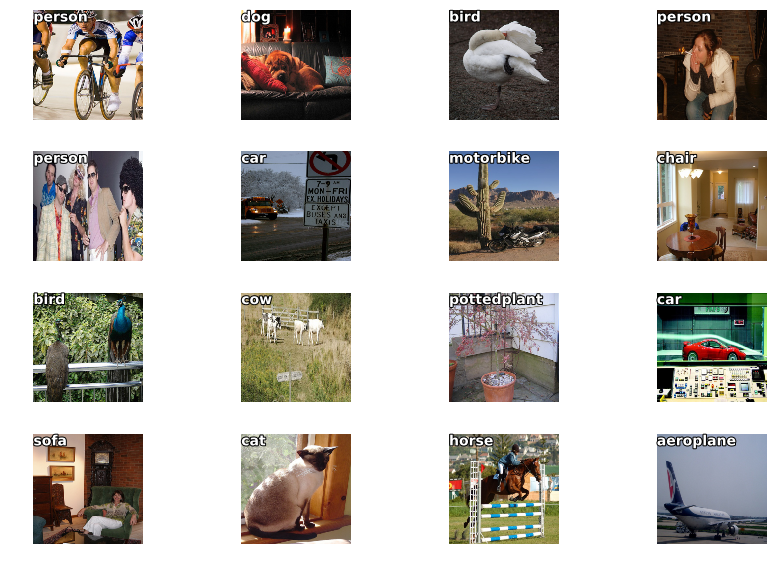

In [98]:
fig, axes = plt.subplots(4,4, figsize=(12,8))
for i,ax in enumerate(axes.flat):
    ax = show_img(x[i], ax=ax)
    draw_text(ax, (0,0), md.classes[preds[i]])
plt.tight_layout()

# bounding box of largest item

done this before: multiple object (ala planet comp) regression (ala rossman)  
- need NN to output 4 numbers (box coordinates)
- need a loss function to determine how close our coordinates are to the real thing (MSError should be fine)

In [26]:
BB_CSV = PATH/'tmp'/'largest_bb.csv'

In [27]:
df = pd.DataFrame({'filename': [trn_imgs[i] for i in trn_ids],
                   'bbox': [' '.join([str(o) for o in lrg_trn[i][0]]) for i in trn_ids]},
                   columns=['filename', 'bbox'])
df.to_csv(BB_CSV, index=False)

In [103]:
custom_reg4 = nn.Sequential(Flatten(), nn.Linear(25088, 1000), nn.Linear(1000, 4))

In [107]:
augs = [RandomRotate(5, tfm_y=TfmType.COORD),
        RandomLighting(0.1, 0.1, tfm_y=TfmType.COORD),
        RandomFlip(tfm_y=TfmType.COORD)]
tfms = tfms_from_model(f, sz, aug_tfms=augs, crop_type=CropType.NO, tfm_y=TfmType.COORD)
data = ImageClassifierData.from_csv(PATH, JPEGS, BB_CSV, bs=16, tfms=tfms, continuous=True)
learn = ConvLearner.pretrained(f, data, ps=0.3, custom_head=custom_reg4)

In [ ]:
learn.lr_find()
learn.sched.plot(n_skip_end=3)

In [108]:
lr=1e-3

In [ ]:
learn.opt_fn = optim.Adam

In [109]:
learn.fit(lr, 2, cycle_len=1, wds=1e-4)

A Jupyter Widget

  1%|          | 1/126 [00:04<09:26,  4.53s/it, loss=124]


Exception in thread Thread-16:
Traceback (most recent call last):
  File "/Users/adamschiller/anaconda3/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/Users/adamschiller/anaconda3/lib/python3.6/site-packages/tqdm/_tqdm.py", line 148, in run
    for instance in self.tqdm_cls._instances:
  File "/Users/adamschiller/anaconda3/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss                              
    0      33.117331  29.636633 
    1      28.822428  27.553595                             



[27.553595001220703]

In [111]:
learn.unfreeze()
lrs = np.array([lr/100, lr/10, lr])

In [112]:
learn.fit(lrs, 2, cycle_len=1, cycle_mult=2)

A Jupyter Widget

epoch      trn_loss   val_loss                              
    0      25.33382   25.325178 
    1      25.037742  29.878762                             
    2      21.593424  22.898007                             



[22.898007110595703]

In [113]:
learn.save('largest_box')

### Check results

In [114]:
x,y = next(iter(data.val_dl))

In [115]:
res = predict_batch(learn.model, x)
res

tensor([[  10.1018,   40.3746,  225.3090,  215.1257],
        [  82.9177,   11.6984,  209.1020,  200.7214],
        [  37.8300,   31.5637,  209.4451,  210.1205],
        [  38.0745,   28.5758,  224.0640,  187.4876],
        [  23.7087,   40.6517,  209.2243,  169.8136],
        [  78.0760,   46.9651,  172.1767,  163.6265],
        [  80.4910,   28.5193,  237.8205,  195.3613],
        [ 140.0305,   55.2751,  211.7907,  145.2105],
        [  49.2785,   62.5563,  215.6848,  222.6737],
        [  38.8792,   69.7814,  151.6999,  147.7355],
        [  88.8693,   52.9783,  191.6857,  142.0045],
        [  91.1465,   33.2712,  187.7813,  193.5997],
        [  87.1886,   58.1426,  205.4595,  182.9109],
        [   7.4666,   36.6471,  201.1171,  207.2323],
        [  24.6191,   64.3792,  226.2900,  222.5632],
        [  62.6929,   -2.3093,  203.3781,  164.4806]])

In [121]:
x = to_np(x)
x = md.val_ds.denorm(x)
res = to_np(res)
y = to_np(y)

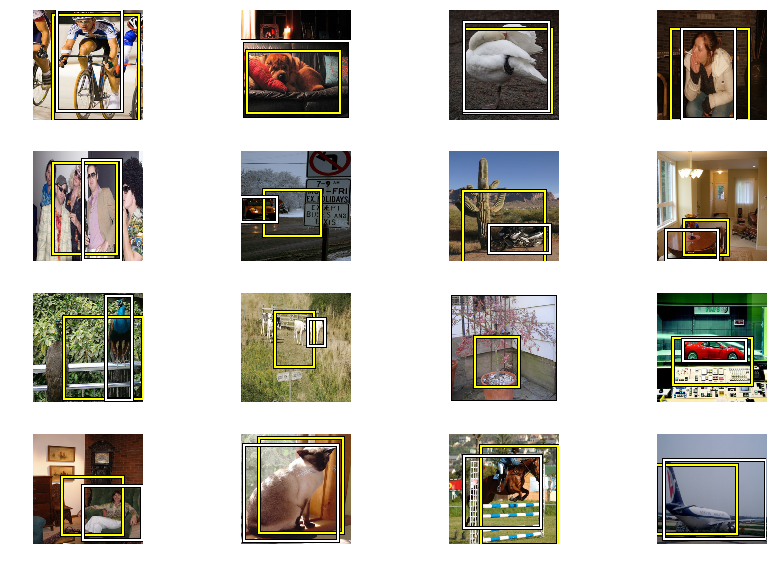

In [123]:
fig, axes = plt.subplots(4,4, figsize=(12,8))
for i,ax in enumerate(axes.flat):
    ax = show_img(x[i], ax=ax)
    draw_rectangle(ax, bb_hw(res[i]), color='yellow')
    draw_rectangle(ax, bb_hw(y[i]))
plt.tight_layout()

# Single Object Detection

In [18]:
f = resnet34
sz = 224
bs = 64

In [19]:
CSV = PATH/'tmp'/'largest_obj.csv'
BB_CSV = PATH/'tmp'/'largest_bb.csv'

In [28]:
augs = [RandomRotate(5, tfm_y=TfmType.COORD),
        RandomLighting(0.1, 0.1, tfm_y=TfmType.COORD),
        RandomFlip(tfm_y=TfmType.COORD)]
tfms = tfms_from_model(f, sz, aug_tfms=augs, crop_type=CropType.NO, tfm_y=TfmType.COORD)
data = ImageClassifierData.from_csv(PATH, JPEGS, BB_CSV, bs=bs, tfms=tfms, continuous=True)

In [29]:
md = ImageClassifierData.from_csv(PATH, JPEGS, CSV, bs=bs, tfms=tfms_from_model(f, sz, aug_tfms=transforms_side_on))

In [30]:
class ConcatLblDataset(Dataset):
    def __init__(self,ds,y2): self.ds, self.y2 = ds,y2
    def __len__(self, ds): return len(self.ds)
    
    def __getitem__(self, i):
        x,y1 = self.ds[i]
        return (x, (y1, self.y2[i]))

In [31]:
trn_ds = ConcatLblDataset(data.trn_ds, md.trn_y) #trn_cats)
val_ds = ConcatLblDataset(data.val_ds, md.val_y) #val_cats)

data.trn_dl.dataset = trn_ds
data.val_dl.dataset = val_ds

### verify combo dataset

In [32]:
x,(y1,y2) = next(iter(data.trn_dl))
x = md.trn_ds.denorm(x)    # need to use md.trn_ds.denorm because data.trn_ds doesn't have one...

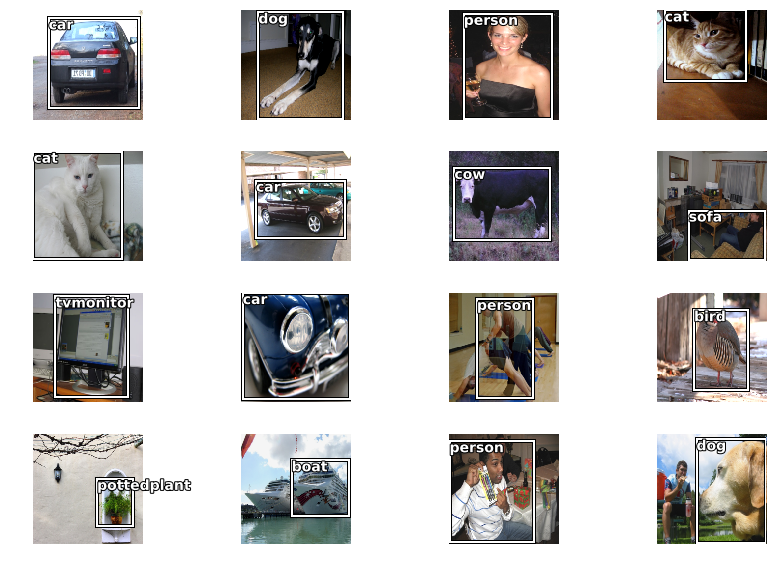

In [33]:
fig, axes = plt.subplots(4,4, figsize=(12,8))
for i,ax in enumerate(axes.flat):
    ax = show_img(x[i], ax=ax)
    b = bb_hw(to_np(y1[0][i]))     #=> this solves error but is problematic... b = bb_hw(to_np(y1[0][i]))
    draw_rectangle(ax, b)
    draw_text(ax, b[:2], md.classes[y2[i]])
plt.tight_layout()

### Arch

In [34]:
custom_sod = nn.Sequential(
    Flatten(),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(25088, 1000),
    nn.ReLU(),
    nn.BatchNorm1d(1000),
    nn.Dropout(0.3),
    nn.Linear(1000, 4+(len(cats)))
)

In [55]:
# can't use ConvLearner.pretrained => doesn't work with custom head 

models = ConvnetBuilder(f, 0, False, False, ps=0.3, custom_head=custom_sod)
learn = ConvLearner(data, models)

In [52]:
def sod_loss(input, target):
    b_targ,c_targ = target
    b_acts,c_acts = input[:,:4], input[:,4:]
    
    box = torch.sigmoid(b_acts)*sz
    box_loss = F.l1_loss(box, b_targ)
    class_loss = F.cross_entropy(c_acts, c_targ)
    
    return box_loss + class_loss*25

def L1_loss(input, target):
    b_targ,_ = target
    b_acts = input[:,:4]
    box = torch.sigmoid(b_acts)*sz
    return F.l1_loss(box, b_targ)

def class_acc(input, target):
    _,c_targ = target
    c_acts = input[:,4:]
    return accuracy(c_acts, c_targ)

In [56]:
learn.opt_fn = optim.Adam
learn.crit = sod_loss
learn.metrics = [L1_loss, class_acc]

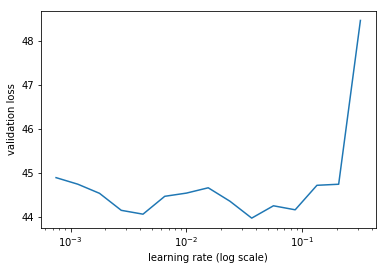

In [54]:
learn.lr_find()
learn.sched.plot(n_skip_end=2)

In [57]:
lr = 1e-2
learn.fit(lr, 3, cycle_len=1)

epoch      trn_loss   val_loss   L1_loss    class_acc     
    0      39.50779   45.426938  29.207521  0.834     
    1      35.470565  42.725777  26.437595  0.83          
    2      33.204861  40.28451   25.414553  0.834         


[40.28450994873047, 25.414552642822265, 0.8340000009536743]

In [58]:
learn.unfreeze()
lrs = np.array([lr/1000, lr/100, lr])
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   L1_loss    class_acc     
    0      33.328464  40.741395  24.677098  0.81      
    1      29.903446  38.859834  23.287113  0.834         
    2      26.420272  37.081898  22.28709   0.83          
    3      24.482399  37.743644  22.311729  0.844         
    4      22.812631  37.762256  21.262865  0.832         
    5      20.890823  35.53133   21.102163  0.832         
    6      19.179576  35.166132  20.444444  0.838         


[35.16613153076172, 20.444444290161133, 0.8379999980926514]

### Check results

In [59]:
x,y = next(iter(data.val_dl))

In [61]:
res = predict_batch(learn.model, x)
res.shape

torch.Size([64, 24])

In [64]:
x = to_np(x)
x = md.val_ds.denorm(x)
res = to_np(res)
acts = res[:,:4]
probs = np.exp(res[:,4:])
preds = np.argmax(probs, axis=1)
y = to_np(y)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


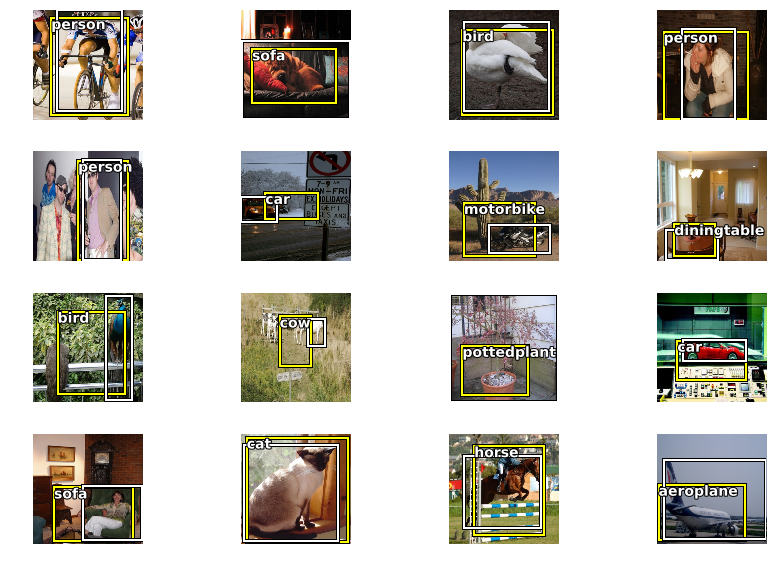

In [87]:
from scipy.special import expit

fig, axes = plt.subplots(4,4, figsize=(12,8))
for i,ax in enumerate(axes.flat):
    ax = show_img(x[i], ax=ax)
    bb = expit(acts[i])*224  #need expit because results are log values
    b = bb_hw(bb)
    draw_text(ax, b[:2], md.classes[preds[i]])
    draw_rectangle(ax, b, color='yellow')
    draw_rectangle(ax, bb_hw(y[0][i]))
plt.tight_layout()

# Multi Object Detection

## DataLoader

In [15]:
multi_classes = np.array([ np.array([ v[1] for v in trn[i] ]) for i in trn_ids ])
multi_classes

array([array([7]), array([15, 13]), array([ 2,  2, 15, 15, 15]), ..., array([18,  9, 15, 15, 15]), array([7]),
       array([12])], dtype=object)

In [16]:
MULTI_CSV = PATH/'tmp'/'multi.csv'

# df = pd.DataFrame({'filename': [trn_imgs[i] for i in trn_ids],
#                    'bbox': [' '.join([' '.join([str(o) for o in v[0]]) for v in trn[i]]) for i in trn_ids]},
#                    columns=['filename', 'bbox'])
# df.to_csv(MULTI_CSV, index=False)
df = pd.read_csv(MULTI_CSV)
df.head(5)

filename                                               bbox
0  000012.jpg                                     96 155 270 351
1  000017.jpg                       61 184 199 279 77 89 336 403
2  000023.jpg  229 8 500 245 219 229 500 334 0 1 369 117 1 2 ...
3  000026.jpg                                     124 89 212 337
4  000032.jpg  77 103 183 375 87 132 123 197 179 194 229 213 ...

In [17]:
f = resnet34
sz = 224
bs = 64

In [18]:
augs = [RandomRotate(5, tfm_y=TfmType.COORD),
        RandomLighting(0.1, 0.1, tfm_y=TfmType.COORD),
        RandomFlip(tfm_y=TfmType.COORD)]
tfms = tfms_from_model(f, sz, aug_tfms=augs, crop_type=CropType.NO, tfm_y=TfmType.COORD)
data = ImageClassifierData.from_csv(PATH, JPEGS, MULTI_CSV, bs=bs, tfms=tfms, continuous=True)

In [19]:
class ConcatLblDataset(Dataset):
    def __init__(self,ds,y2): self.ds, self.y2 = ds,y2
    def __len__(self, ds): return len(self.ds)
    
    def __getitem__(self, i):
        x,y1 = self.ds[i]
        return (x, (y1, self.y2[i]))

In [20]:
val_idxs = get_cv_idxs(len(multi_classes))
((val_cats,trn_cats),) = split_by_idx(val_idxs, multi_classes)

In [21]:
multi_trn = ConcatLblDataset(data.trn_ds, trn_cats)
multi_val = ConcatLblDataset(data.val_ds, val_cats)

data.trn_dl.dataset = multi_trn
data.val_dl.dataset = multi_val

In [22]:
data.trn_dl.pre_pad = False
data.val_dl.pre_pad = False

### Verify

In [23]:
x,(y1, y2) = next(iter(data.val_dl))
img_x = to_np( data.trn_ds.ds.denorm(x) )

In [42]:
y1[-1], y2[-1]

(tensor([ 46.,  33., 222., 191.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]),
 tensor([10,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]))

In [24]:
import matplotlib.cm as cmx
import matplotlib.colors as mcolors
from cycler import cycler

def get_cmap(N):
    color_norm  = mcolors.Normalize(vmin=0, vmax=N-1)
    return cmx.ScalarMappable(norm=color_norm, cmap='Set3').to_rgba

num_colr = 12
cmap = get_cmap(num_colr)
colr_list = [cmap(float(x)) for x in range(num_colr)]

def show_ground_truth(ax, im, bbox, clas=None, prs=None, thresh=0.3):
    bb = [bb_hw(o) for o in bbox.reshape(-1,4)]
    if prs is None:  prs  = [None]*len(bb)
    if clas is None: clas = [None]*len(bb)
    ax = show_img(im, ax=ax)
    for i,(b,c,pr) in enumerate(zip(bb, clas, prs)):
        if((b[2]>0) and (pr is None or pr > thresh)):
            c = c.item()
            draw_rectangle(ax, b, color=colr_list[i%num_colr])
            txt = f'{i}: '
            if c is not None: txt += ('bg' if c==len(cats) else cats[c])
            if pr is not None: txt += f' {pr:.2f}'
            draw_text(ax, b[:2], txt, color=colr_list[i%num_colr])

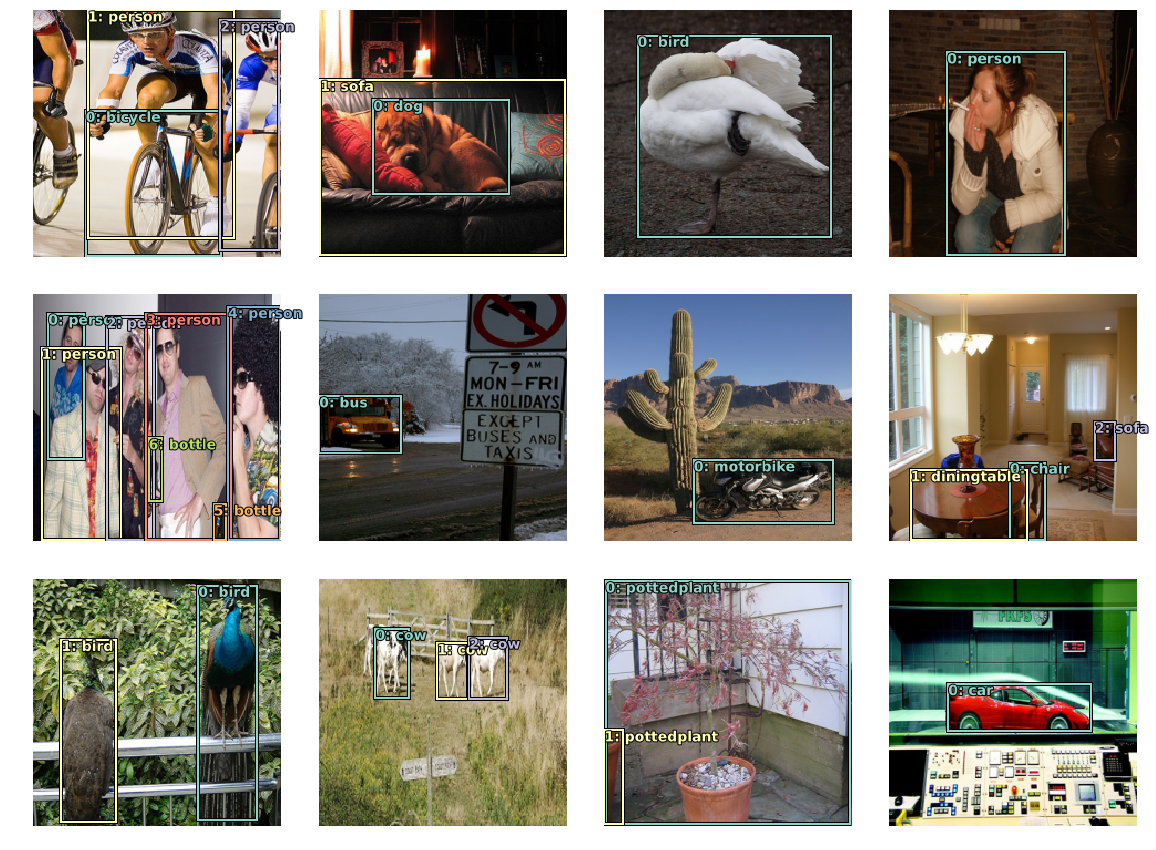

In [25]:
fig, axes = plt.subplots(3, 4, figsize=(16, 12))
for i,ax in enumerate(axes.flat):
    show_ground_truth(ax, img_x[i], y1[i], y2[i])
plt.tight_layout()

## Arch

In [26]:
class std_conv(nn.Module):
    def __init__(self, nin, nout, stride, drop=0.2): 
        super().__init__()
        self.conv = nn.Conv2d(nin, nout, 3, stride=stride, padding=1)
        self.bn = nn.BatchNorm2d(nout)
        self.drop = nn.Dropout(drop)
        
    def forward(self, x): return self.drop(self.bn(F.relu(self.conv(x))))
    
def flatten_conv(x,k):
    bs,nf,h,w = x.size()
    x = x.permute(0,2,3,1).contiguous()
    return x.view(bs,-1,nf//k)

class out_conv(nn.Module):
    def __init__(self, k, nin):
        super().__init__()
        self.k = k
        self.b_conv = nn.Conv2d(nin, k*4, 3, padding=1)
        self.c_conv = nn.Conv2d(nin, k*(len(cats)+1), 3, padding=1)  # +1 for bg
    
    def forward(self, x):
        return [flatten_conv(self.b_conv(x), self.k), flatten_conv(self.c_conv(x), self.k)]

In [27]:
class SSD_SingleHead(nn.Module):
    def __init__(self, k):
        super().__init__()
        self.drop = nn.Dropout(0.3)
        self.conv0 = std_conv(512, 256, stride=1)
        self.conv1 = std_conv(256, 256, stride=2)
        self.out = out_conv(k, 256)
        
    def forward(self, x):
        x = self.drop(F.relu(x))
        x = self.conv0(x)
        x = self.conv1(x)
        return self.out(x)

In [28]:
class SSD_MultiHead(nn.Module):
    def __init__(self, k):
        super().__init__()
        self.drop = nn.Dropout(0.3)
        self.conv0 = std_conv(512, 256, stride=1)
        self.conv1 = std_conv(256, 256, stride=2)
        self.conv2 = std_conv(256, 256, stride=2)
        self.conv3 = std_conv(256, 256, stride=2)
        self.out1 = out_conv(k, 256)
        self.out2 = out_conv(k, 256)
        self.out3 = out_conv(k, 256)
        
    def forward(self, x):
        x = self.drop(F.relu(x))
        x = self.conv0(x)
        x = self.conv1(x)
        ob1,oc1 = self.out1(x)  # 16 (4x4)
        x = self.conv2(x)
        ob2,oc2 = self.out2(x)  # 4 (2x2)
        x = self.conv3(x)
        ob3,oc3 = self.out3(x)  # 1 (1x1)
        return [torch.cat([ob1, ob2, ob3], dim=1), torch.cat([oc1, oc2, oc3], dim=1)]

In [29]:
# cust_head = SSD_SingleHead(1)  #bias not being used here => loss fn
cust_head = SSD_MultiHead(9)
models = ConvnetBuilder(f, 0, False, False, custom_head=cust_head)
learn = ConvLearner(data, models)

### Verify

In [108]:
#x,(y1,y2) = next(iter(data.trn_dl)) from above...
learn.model.eval()
preds = learn.model(x)
p_box, p_clas = preds
p_box.shape, p_clas.shape

(torch.Size([64, 189, 4]), torch.Size([64, 189, 21]))

## Loss function

In [31]:
anc_grids = [4,2,1]
anc_zooms = [0.7, 1., 1.3]
anc_ratios = [(1.,1.), (1.,0.5), (0.5,1.)]
anchor_scales = [(anz*i,anz*j) for anz in anc_zooms for (i,j) in anc_ratios]
k = len(anchor_scales)
anc_offsets = [1/(o*2) for o in anc_grids]  #1/8, 1/4, 1/2

anc_x = np.concatenate([np.repeat(np.linspace(ao, 1-ao, ag), ag)
                        for ao,ag in zip(anc_offsets,anc_grids)])
anc_y = np.concatenate([np.tile(np.linspace(ao, 1-ao, ag), ag)
                        for ao,ag in zip(anc_offsets,anc_grids)])
anc_ctrs = np.repeat(np.stack([anc_x,anc_y], axis=1), k, axis=0)

anc_sizes  = np.concatenate([np.array([[o/ag,p/ag] for i in range(ag*ag) for o,p in anchor_scales])
             for ag in anc_grids])
grid_sizes = V(np.concatenate([np.array([ 1/ag for i in range(ag*ag) for o,p in anchor_scales])
             for ag in anc_grids]), requires_grad=False).unsqueeze(1)
anchors = V(np.concatenate([anc_ctrs, anc_sizes], axis=1), requires_grad=False).float()  # (center(x,y), size(h,w))

def hw2corners(ctr, hw): return torch.cat([ctr-hw/2, ctr+hw/2], dim=1)
anchor_cnr = hw2corners(anchors[:,:2], anchors[:,2:])  #=> bb

len(anchors), k

(189, 9)

In [99]:
def one_hot_embedding(labels, num_classes):
    return torch.eye(num_classes)[labels.data.cpu()]

class BCE_Loss(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes+1

    def forward(self, pred, targ):
        t = one_hot_embedding(targ, self.num_classes)
#         t = V(t[:,:-1].contiguous())#.cpu()  # subtracts last class (bg)
#         x = pred[:,:-1]                      # subtract last class (bg)
        x = pred
        w = self.get_weight(x,t)
        return F.binary_cross_entropy_with_logits(x, t, w)/self.num_classes
    
    def get_weight(self,x,t): return None

class_loss_fn = BCE_Loss(len(cats))

In [100]:
def intersect(box_a, box_b):
    max_xy = torch.min(box_a[:, None, 2:], box_b[None, :, 2:])
    min_xy = torch.max(box_a[:, None, :2], box_b[None, :, :2])
    inter = torch.clamp((max_xy - min_xy), min=0)
    return inter[:, :, 0] * inter[:, :, 1]

def box_sz(b): return ((b[:, 2]-b[:, 0]) * (b[:, 3]-b[:, 1]))

def jaccard(box_a, box_b):
    inter = intersect(box_a, box_b)
    union = box_sz(box_a).unsqueeze(1) + box_sz(box_b).unsqueeze(0) - inter
    return inter / union

In [104]:
def get_y(box, clas):
    # return actual objects/boxes (remove 0 padding)
    keep = clas.nonzero().squeeze(1)
    b = box.view(-1,4)
    return b[keep],clas[keep]

def activations_to_anchors2(box):
    # not transforming properly
    bbs = torch.sigmoid(box)+0.5    #=> from .75 to 1.25 generally
    ancs = anchor_cnr*bbs*224
    return ancs

def activations_to_anchors1(box):
    bbs = torch.tanh(box)
    centers = (bbs[:,:2]/2 * grid_sizes) + anchors[:,:2]
    hw = (bbs[:,2:]/2+1) * anchors[:,2:]  
    return hw2corners(centers, hw)*224

def single_ssd_loss(x_box,x_clas,y_box,y_clas):
    y_box, y_clas = get_y(y_box, y_clas)
    # find best anchor overlap w/ gt
    overlaps = jaccard(y_box,anchor_cnr*224)  # using anchor_cnr as comparison => don't modify!!
    amts, idxs = overlaps.max(1)
    
    actn_anchors = activations_to_anchors1(x_box)[idxs]   # returns transformed overlapping anchors
#     actn_anchors = activations_to_anchors2(x_box)[idxs]   # returns transformed overlapping anchors

    
    b_loss = F.l1_loss(actn_anchors, y_box)
    c_loss = class_loss_fn(x_clas[idxs], y_clas)
    return b_loss, c_loss

def ssd_loss(input, target, print_it=False):
    class_loss = 0.
    box_loss = 0.
    for x_box,x_clas,y_box,y_clas in zip(*input,*target):
        b_loss, c_loss = single_ssd_loss(x_box,x_clas,y_box,y_clas)
        box_loss += b_loss
        class_loss += c_loss
    if print_it: print(f'box: {box_loss.item()}, class: {class_loss.item()}')
    return box_loss + class_loss*50

In [105]:
ssd_loss(preds, (y1, y2), True)

box: 1016.3155517578125, class: 2.110619306564331


tensor(1121.8466, grad_fn=<ThAddBackward>)

In [109]:
# after 1 cycle
ssd_loss(preds, (y1, y2), True)

box: 1680.29296875, class: 1.0114582777023315


tensor(1730.8658, grad_fn=<ThAddBackward>)

### testing loss fn

In [110]:
idx=7
p_clasi = p_clas[idx]
p_boxi = p_box[idx]
ima = img_x[idx]
b,c = get_y(y1[idx], y2[idx])
b,c

(tensor([[152., 109., 222., 141.],
         [159.,  19., 222., 124.],
         [115., 186., 150., 204.]]), tensor([ 9, 11, 18]))

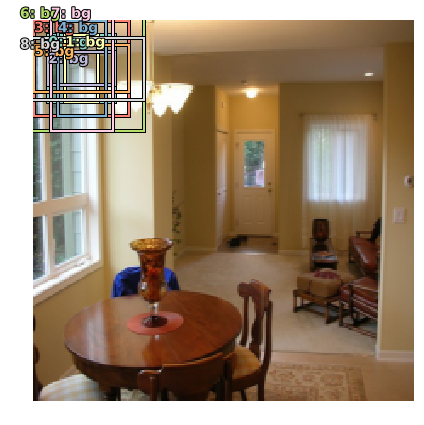

In [36]:
# show set of anchors
fig, ax = plt.subplots(figsize=(7,7))
show_ground_truth(ax, ima, anchor_cnr[:9]*224, torch.ones(9)*len(cats))

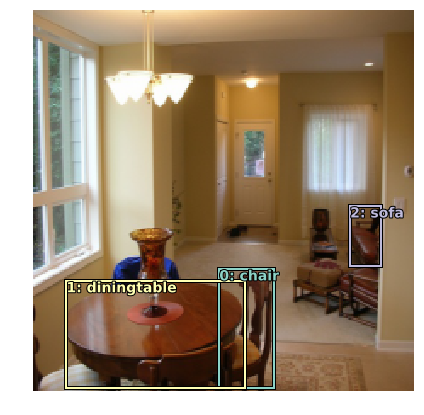

In [37]:
# show gt boxes
fig, ax = plt.subplots(figsize=(7,7))
show_ground_truth(ax, ima, b, c)

In [111]:
# find best overlap btw gt and anchors
overlaps = jaccard(b,anchor_cnr*224)
amts, idxs = overlaps.max(1)
amts, idxs

(tensor([0.4110, 0.6162, 0.6046]), tensor([129, 123, 100]))

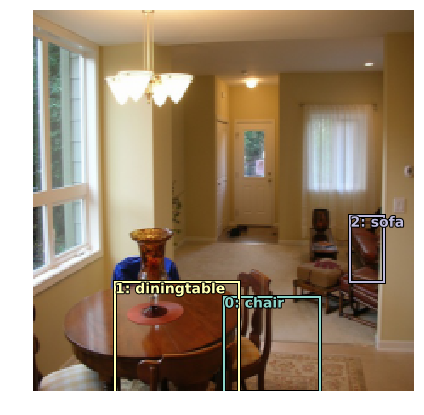

In [112]:
# show best overlapping anchors
fig, ax = plt.subplots(figsize=(7,7))
show_ground_truth(ax, ima, anchor_cnr[idxs]*224, c)

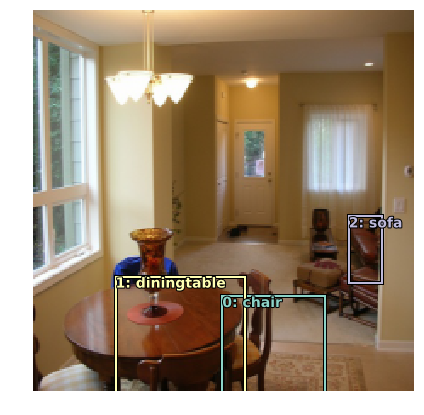

In [40]:
# apply activations at those idxs to the anchors (transformation)
bbs = torch.sigmoid(p_boxi[idxs])+0.5    #=> from .75 to 1.25 generally

# new_bbs = anchor_cnr[idxs]*bbs*224

# show overlapping anchors w/ activations applied
fig, ax = plt.subplots(figsize=(7,7))
show_ground_truth(ax, ima, anchor_cnr[idxs]*224*bbs, c)

### train

In [106]:
learn.crit = ssd_loss
learn.opt_fn = optim.Adam

A Jupyter Widget

  0%|          | 0/32 [00:00<?, ?it/s]

/Users/adamschiller/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


 94%|█████████▍| 30/32 [04:26<00:17,  8.88s/it, loss=1.38e+04]

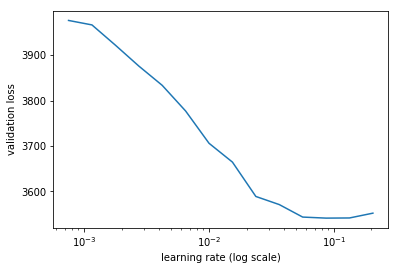

In [44]:
learn.lr_find()
learn.sched.plot()

In [97]:
lr=2e-2

In [107]:
learn.fit(lr, 1, cycle_len=1)

A Jupyter Widget

  0%|          | 0/32 [00:00<?, ?it/s]                        


Exception in thread Thread-7:
Traceback (most recent call last):
  File "/Users/adamschiller/anaconda3/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/Users/adamschiller/anaconda3/lib/python3.6/site-packages/tqdm/_tqdm.py", line 148, in run
    for instance in self.tqdm_cls._instances:
  File "/Users/adamschiller/anaconda3/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss                                
    0      1969.07211 1758.028138



[1758.0281376953126]